# Autoencoder


*   Produced by Lida Zhang



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from statsmodels.tsa.api import SARIMAX

## Data Cleansing

In [3]:
df = pd.read_csv('/content/drive/My Drive/Autoencoder-FRED-MD/transformed_data.csv')
df.head()

,date,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
0,1/1/1959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2/1/1959,0.003931,0.003613,0.010368,0.007358,0.007310,0.019395,0.013404,0.008623,0.007310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3/1/1959,0.006430,0.007359,0.009410,-0.003423,0.008321,0.014303,0.006036,0.004899,0.000000,...,-0.001124,0.000262,-0.000022,-0.008147,0.004819,NaN,0.004929,0.004138,-0.014792,NaN
3,4/1/1959,0.006494,0.007049,-0.003639,0.019922,0.000616,0.021077,0.014338,0.014542,0.015653,...,0.001349,0.001752,-0.000022,0.012203,-0.004890,NaN,0.012134,0.006734,0.024929,NaN
4,5/1/1959,0.005763,0.006616,0.012005,0.006797,0.007803,0.014950,0.008269,0.009583,0.004768,...,-0.001687,-0.001937,-0.000021,-0.004090,-0.004819,NaN,0.002828,0.002020,-0.015342,NaN


In [4]:
df_head10 = df.head(10)
df_head10.dropna(axis=1, how='all', inplace=True)    # drop columns with first 10 rows all blank

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [5]:
df = df[list(df_head10.columns)]
df = df.iloc[2:-1,:] # drop first two rows with most NA values and the last row which is all blank
df.fillna(method='ffill',inplace=True) # forward fill other NA values

In [6]:
df.isna().sum().sum() # check if any NA remains

0

In [7]:
df.shape

(756, 118)

In [8]:
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df['date']

2     1959-03-01
3     1959-04-01
4     1959-05-01
5     1959-06-01
6     1959-07-01
         ...    
753   2021-10-01
754   2021-11-01
755   2021-12-01
756   2022-01-01
757   2022-02-01
Name: date, Length: 756, dtype: datetime64[ns]

In [9]:
df = df.set_index('date').asfreq('MS') # Month Start Freq
df.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST
date,,,,,,,,,,,,,,,,,,,,,
1959-03-01,0.006430,0.007359,0.009410,-0.003423,0.008321,0.014303,0.006036,0.004899,0.000000,0.019397,...,-0.000250,0.000666,-0.001124,0.000262,-0.000022,-0.008147,0.004819,0.004929,0.004138,-0.014792
1959-04-01,0.006494,0.007049,-0.003639,0.019922,0.000616,0.021077,0.014338,0.014542,0.015653,0.006379,...,0.001305,-0.000229,0.001349,0.001752,-0.000022,0.012203,-0.004890,0.012134,0.006734,0.024929
1959-05-01,0.005763,0.006616,0.012005,0.006797,0.007803,0.014950,0.008269,0.009583,0.004768,0.020151,...,-0.001431,0.000646,-0.001687,-0.001937,-0.000021,-0.004090,-0.004819,0.002828,0.002020,-0.015342
1959-06-01,0.003102,0.002974,0.003708,-0.000052,0.009064,0.001144,0.007034,0.007126,-0.004768,0.007452,...,0.002293,0.000329,0.003316,0.002093,-0.004619,0.003992,0.004796,0.009726,0.009007,-0.012252
1959-07-01,-0.000589,-0.000764,-0.003427,0.012110,-0.000330,-0.024238,0.001167,0.008247,0.013056,0.019613,...,-0.000749,-0.001521,-0.001238,-0.000100,0.000000,-0.004040,-0.004796,-0.004631,-0.001000,0.029341


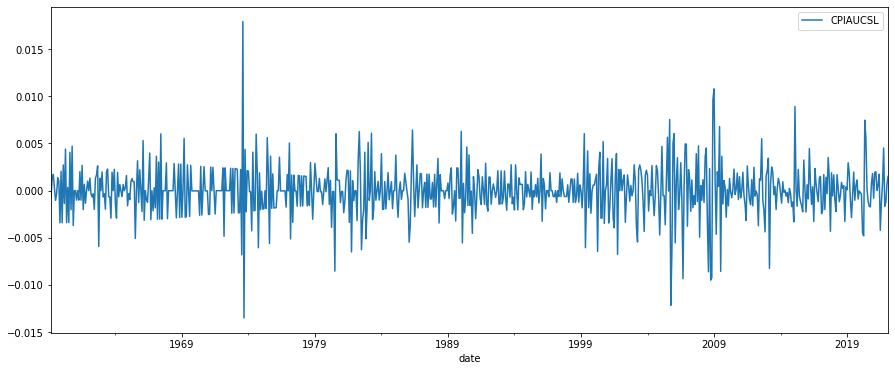

In [10]:
y = df[['CPIAUCSL']]      # CPI all items
y.plot(figsize=(15, 6))
plt.show()

In [11]:
df.pop('CPIAUCSL')

date
1959-03-01   -0.000690
1959-04-01    0.001380
1959-05-01    0.001723
1959-06-01    0.000339
1959-07-01   -0.001034
                ...   
2021-10-01    0.004527
2021-11-01   -0.001659
2021-12-01   -0.001233
2022-01-01    0.000695
2022-02-01    0.001515
Freq: MS, Name: CPIAUCSL, Length: 756, dtype: float64

## Models

### Autoencoder

In [14]:
def Autoencoder(window_x, window_x_all):
    # change to array
    window_x_array = np.array(window_x)

    # split training set & validation set
    n_train = int(0.75*(len(window_x_array)))
    n_val = len(window_x_array)-n_train
    x_train = window_x_array[:n_train]
    x_val = window_x_array[-n_val:]

    # hyperparameters
    original_dim = 116
    intermediate_dim = 32
    latent_dim = 10

    # define encoder
    encoder_input = keras.Input(shape=(original_dim,))
    x = layers.Dense(intermediate_dim, activation='relu')(encoder_input)
    encoder_output = layers.Dense(latent_dim, activation='relu')(x)
    encoder = keras.Model(encoder_input, encoder_output, name='encoder')

    # define decoder
    decoder_input = keras.Input(shape=(latent_dim,))
    x = layers.Dense(intermediate_dim, activation='relu')(decoder_input)
    decoder_output = layers.Dense(original_dim, activation='relu')(x)
    decoder = keras.Model(decoder_input, decoder_output, name='decoder')

    # define autoencoder
    autoencoder_input = keras.Input(shape=(original_dim,))
    encoded = encoder(autoencoder_input)
    decoded = decoder(encoded)
    autoencoder = keras.Model(autoencoder_input, decoded, name="autoencoder")
    
    autoencoder.compile(optimizer='adam', loss='mae')
    history = autoencoder.fit(x_train, x_train,
                epochs=300,
                batch_size=16,
                validation_data=(x_val, x_val))
    
    # encode
    window_x_encoded = pd.DataFrame(encoder.predict(window_x_all), index=window_x_all.index)

    return history, window_x_encoded

### Time Series Predictive Model



In [15]:
def Forecast(window_x_encoded, window_x, window_y, window_y_test, window_y_all):
    forecasts = []
    nobs = len(window_x_encoded)
    n_init_training = len(window_x)
    init_training_exog = window_x_encoded.iloc[:n_init_training]
    tsmodel = SARIMAX(window_y, exog=init_training_exog, order=(4, 0, 0))
    tsmodel_res = tsmodel.fit()
    forecasts.append(tsmodel_res.forecast(exog=init_training_exog.iloc[-1:,:], steps=1))
    for t in range(n_init_training, nobs-1):
        # Update the results by appending the next observation
        updated_endog = window_y_all.iloc[:t+1]
        updated_exog = window_x_encoded.iloc[:t+1]
        tsmodel = SARIMAX(updated_endog, exog=updated_exog, order=(4, 0, 0))
        tsmodel_res = tsmodel.fit()
        # Save the new set of forecasts
        forecasts.append(tsmodel_res.forecast(exog=updated_exog.iloc[-1:,:], steps=1))
    # Combine all forecasts into a dataframe
    forecasts_df = pd.DataFrame(forecasts)
    flattened = forecasts_df.apply(lambda x: x.dropna().reset_index(drop=True)).T
    flattened.rename(columns={0:'Forecasts_Autoencoder'}, inplace=True)

    # AR(4)
    forecasts_ar4 = []
    ar4 = SARIMAX(window_y_all.iloc[:n_init_training], order=(4, 0, 0))
    ar4_res = ar4.fit()
    forecasts_ar4.append(ar4_res.forecast(steps=1))
    for t in range(n_init_training, nobs-1):
        updated_endog = window_y_all.iloc[:t+1]
        ar4 = SARIMAX(updated_endog, order=(4, 0, 0))
        ar4_res = ar4.fit()
        forecasts_ar4.append(ar4_res.forecast(steps=1))
    forecasts_ar4_df = pd.DataFrame(forecasts_ar4)
    flattened_ar4 = forecasts_ar4_df.apply(lambda x: x.dropna().reset_index(drop=True)).T
    flattened_ar4.rename(columns={0:'Forecasts_AR4'}, inplace=True)
    df_mse = pd.concat([window_y_test, flattened, flattened_ar4], axis=1)
    mse_autoencoder = ((df_mse['Forecasts_Autoencoder']-df_mse['CPIAUCSL'])**2).mean()
    mse_ar4 = ((df_mse['Forecasts_AR4']-df_mse['CPIAUCSL'])**2).mean()
    RMSE = mse_autoencoder/mse_ar4

    return mse_autoencoder, mse_ar4, RMSE

## Store outputs in a list of RMSE

In [16]:
RMSE = []

## Model Training

### Window 1

*   Training Set：1959/3 - 1969/12
*   Test Set：1970/1 - 1990/12

In [17]:
# Training Set：1959/3-1969/12
window1_x = df.loc[:'1969-12-01',:]
window1_y = y[:'1969-12-01']
# Test Set：1970/1-1990/12
window1_x_test = df.loc['1970-01-01':'1990-12-01',:]
window1_y_test = y['1970-01-01':'1990-12-01']
# All
window1_x_all = pd.concat([window1_x, window1_x_test])
window1_y_all = pd.concat([window1_y, window1_y_test])

In [18]:
history1, window1_x_encoded = Autoencoder(window1_x, window1_x_all)

Epoch 1/300
7/7 [==============================] - 3s 27ms/step - loss: 1.8460 - val_loss: 1.8857
Epoch 2/300
7/7 [==============================] - 0s 6ms/step - loss: 1.6362 - val_loss: 1.7292
Epoch 3/300
7/7 [==============================] - 0s 7ms/step - loss: 1.5314 - val_loss: 1.6469
Epoch 4/300
7/7 [==============================] - 0s 7ms/step - loss: 1.4831 - val_loss: 1.6032
Epoch 5/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4569 - val_loss: 1.5767
Epoch 6/300
7/7 [==============================] - 0s 6ms/step - loss: 1.4345 - val_loss: 1.5511
Epoch 7/300
7/7 [==============================] - 0s 9ms/step - loss: 1.4007 - val_loss: 1.5071
Epoch 8/300
7/7 [==============================] - 0s 6ms/step - loss: 1.3470 - val_loss: 1.4365
Epoch 9/300
7/7 [==============================] - 0s 9ms/step - loss: 1.2634 - val_loss: 1.3335
Epoch 10/300
7/7 [==============================] - 0s 6ms/step - loss: 1.1580 - val_loss: 1.2639
Epoch 11/300
7/7 [==========

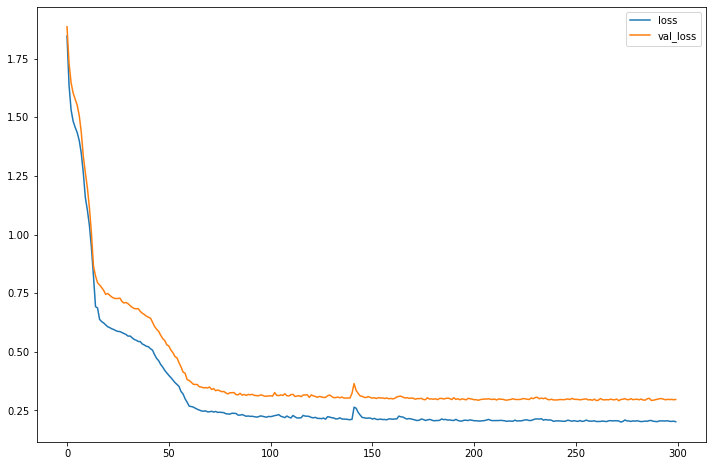

In [19]:
# plot
pd.DataFrame(history1.history).plot(figsize=(12,8))

In [20]:
window1_x_encoded

,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
1959-03-01,32.429161,0.0,13.278973,0.000000,51.320377,9.972580,23.415503,23.362095,49.592510,5.354098
1959-04-01,28.744411,0.0,14.448424,0.000000,39.722813,14.027919,20.938780,13.370446,43.734100,10.283360
1959-05-01,29.570614,0.0,14.293943,0.000000,39.495129,13.908662,20.974979,13.588211,43.513226,10.289589
1959-06-01,27.938013,0.0,14.548271,0.000000,38.806316,14.374621,21.073589,12.550259,43.631142,10.623373
1959-07-01,22.605736,0.0,16.837137,0.000000,21.314425,20.858639,16.892132,0.000000,35.854694,19.280796
...,...,...,...,...,...,...,...,...,...,...
1990-08-01,11.558074,0.0,26.609684,0.767708,16.449213,29.415489,22.506536,0.000000,36.552776,41.231159
1990-09-01,11.241474,0.0,25.941576,0.365005,15.992781,28.590187,21.788054,0.000000,36.059479,40.237885
1990-10-01,12.695739,0.0,28.254068,1.546240,17.445675,31.051481,23.891037,0.000000,37.721199,44.122459


In [21]:
window1_x_encoded.sum()

0     8718.453125
1        0.000000
2     6876.435547
3       52.640167
4    12274.926758
5     7494.814941
6     7944.902832
7     3647.552490
8    16127.726562
9     7498.569336
dtype: float32

In [22]:
window1_x_encoded.drop(window1_x_encoded.columns[[1]], axis=1, inplace=True) # drop columns with close-to-zero sum
window1_x_encoded

,0,2,3,4,5,6,7,8,9
date,,,,,,,,,
1959-03-01,32.429161,13.278973,0.000000,51.320377,9.972580,23.415503,23.362095,49.592510,5.354098
1959-04-01,28.744411,14.448424,0.000000,39.722813,14.027919,20.938780,13.370446,43.734100,10.283360
1959-05-01,29.570614,14.293943,0.000000,39.495129,13.908662,20.974979,13.588211,43.513226,10.289589
1959-06-01,27.938013,14.548271,0.000000,38.806316,14.374621,21.073589,12.550259,43.631142,10.623373
1959-07-01,22.605736,16.837137,0.000000,21.314425,20.858639,16.892132,0.000000,35.854694,19.280796
...,...,...,...,...,...,...,...,...,...
1990-08-01,11.558074,26.609684,0.767708,16.449213,29.415489,22.506536,0.000000,36.552776,41.231159
1990-09-01,11.241474,25.941576,0.365005,15.992781,28.590187,21.788054,0.000000,36.059479,40.237885
1990-10-01,12.695739,28.254068,1.546240,17.445675,31.051481,23.891037,0.000000,37.721199,44.122459


In [23]:
mse_autoencoder_1, mse_ar4_1, RMSE_1 = Forecast(window1_x_encoded, window1_x, window1_y, window1_y_test, window1_y_all)
RMSE.append(RMSE_1)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: 

In [24]:
RMSE

[1.1257829123084027]

### Window 2

*   Training Set：1959/3 - 1979/12
*   Test Set：1980/1 - 2000/12

In [25]:
# Training Set：1959/3-1979/12
window2_x = df.loc[:'1979-12-01',:]
window2_y = y[:'1979-12-01']
# Test Set：1980/1-2000/12
window2_x_test = df.loc['1980-01-01':'2000-12-01',:]
window2_y_test = y['1980-01-01':'2000-12-01']
# All
window2_x_all = pd.concat([window2_x, window2_x_test])
window2_y_all = pd.concat([window2_y, window2_y_test])

In [26]:
history2, window2_x_encoded = Autoencoder(window2_x, window2_x_all)

Epoch 1/300
12/12 [==============================] - 0s 13ms/step - loss: 1.7723 - val_loss: 1.8978
Epoch 2/300
12/12 [==============================] - 0s 6ms/step - loss: 1.6202 - val_loss: 1.8025
Epoch 3/300
12/12 [==============================] - 0s 5ms/step - loss: 1.5673 - val_loss: 1.7713
Epoch 4/300
12/12 [==============================] - 0s 5ms/step - loss: 1.5383 - val_loss: 1.7252
Epoch 5/300
12/12 [==============================] - 0s 5ms/step - loss: 1.4684 - val_loss: 1.5904
Epoch 6/300
12/12 [==============================] - 0s 6ms/step - loss: 1.3314 - val_loss: 1.4777
Epoch 7/300
12/12 [==============================] - 0s 6ms/step - loss: 1.2415 - val_loss: 1.3920
Epoch 8/300
12/12 [==============================] - 0s 4ms/step - loss: 1.1479 - val_loss: 1.2535
Epoch 9/300
12/12 [==============================] - 0s 6ms/step - loss: 0.9907 - val_loss: 1.0132
Epoch 10/300
12/12 [==============================] - 0s 6ms/step - loss: 0.7673 - val_loss: 0.9776
Epoch 11

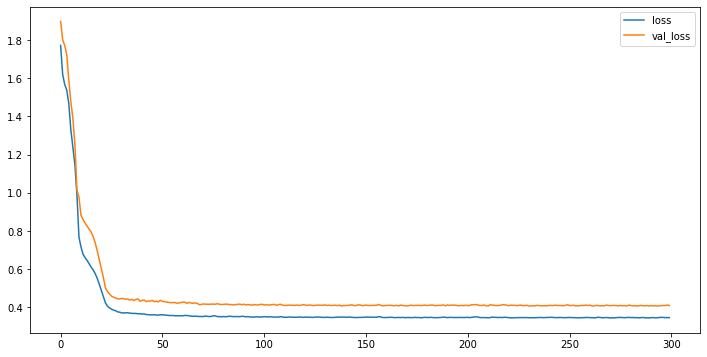

In [27]:
pd.DataFrame(history2.history).plot(figsize=(12,6))

In [28]:
window2_x_encoded

,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
1959-03-01,0.000000,6.797709,6.739719,35.160347,6.780013,0.000000,0.0,31.318581,44.841393,8.237366
1959-04-01,0.000000,9.021619,8.744102,24.470831,10.087371,0.000000,0.0,31.299471,32.369671,12.318497
1959-05-01,0.000000,8.898165,9.076794,24.615067,9.370927,0.000000,0.0,31.008415,32.750435,12.445262
1959-06-01,0.000000,9.285912,8.549396,23.558506,10.658425,0.000000,0.0,31.536856,31.370247,12.594826
1959-07-01,0.000000,12.612772,11.460405,7.719868,14.704993,0.000000,0.0,30.674177,12.991259,18.661793
...,...,...,...,...,...,...,...,...,...,...
2000-08-01,0.000000,23.101873,0.192082,6.318798,25.014938,18.016270,0.0,31.649933,4.900612,32.273247
2000-09-01,0.768723,3.588201,3.373564,58.091629,7.825440,0.000000,0.0,32.765484,65.598763,4.835361
2000-10-01,0.000000,17.187805,9.995414,0.507670,20.716700,0.000000,0.0,32.498016,3.532570,21.530853


In [29]:
window2_x_encoded.sum()

0      384.117645
1     6113.278809
2     4319.628906
3     9523.168945
4     7344.759766
5      710.112976
6        6.474932
7    15922.972656
8    11351.367188
9     8166.757324
dtype: float32

In [30]:
window2_x_encoded.drop(window2_x_encoded.columns[[6]], axis=1, inplace=True)
window2_x_encoded

,0,1,2,3,4,5,7,8,9
date,,,,,,,,,
1959-03-01,0.000000,6.797709,6.739719,35.160347,6.780013,0.000000,31.318581,44.841393,8.237366
1959-04-01,0.000000,9.021619,8.744102,24.470831,10.087371,0.000000,31.299471,32.369671,12.318497
1959-05-01,0.000000,8.898165,9.076794,24.615067,9.370927,0.000000,31.008415,32.750435,12.445262
1959-06-01,0.000000,9.285912,8.549396,23.558506,10.658425,0.000000,31.536856,31.370247,12.594826
1959-07-01,0.000000,12.612772,11.460405,7.719868,14.704993,0.000000,30.674177,12.991259,18.661793
...,...,...,...,...,...,...,...,...,...
2000-08-01,0.000000,23.101873,0.192082,6.318798,25.014938,18.016270,31.649933,4.900612,32.273247
2000-09-01,0.768723,3.588201,3.373564,58.091629,7.825440,0.000000,32.765484,65.598763,4.835361
2000-10-01,0.000000,17.187805,9.995414,0.507670,20.716700,0.000000,32.498016,3.532570,21.530853


In [31]:
mse_autoencoder_2, mse_ar4_2, RMSE_2 = Forecast(window2_x_encoded, window2_x, window2_y, window2_y_test, window2_y_all)
RMSE.append(RMSE_2)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: 

In [32]:
RMSE

[1.1257829123084027, 1.220821891695937]

### Window 3

*   Training Set：1959/3 - 1989/12
*   Test Set：1990/1 - 2009/12

In [33]:
# Training Set：1959/3-1989/12
window3_x = df.loc[:'1989-12-01',:]
window3_y = y[:'1989-12-01']
# Test Set：1990/1-2009/12
window3_x_test = df.loc['1990-01-01':'2009-12-01',:]
window3_y_test = y['1990-01-01':'2009-12-01']
# All
window3_x_all = pd.concat([window3_x, window3_x_test])
window3_y_all = pd.concat([window3_y, window3_y_test])

In [34]:
history3, window3_x_encoded = Autoencoder(window3_x, window3_x_all)

Epoch 1/300
18/18 [==============================] - 1s 9ms/step - loss: 2.2978 - val_loss: 2.2552
Epoch 2/300
18/18 [==============================] - 0s 5ms/step - loss: 1.7778 - val_loss: 1.9793
Epoch 3/300
18/18 [==============================] - 0s 4ms/step - loss: 1.6490 - val_loss: 1.8800
Epoch 4/300
18/18 [==============================] - 0s 4ms/step - loss: 1.5640 - val_loss: 1.7258
Epoch 5/300
18/18 [==============================] - 0s 4ms/step - loss: 1.4104 - val_loss: 1.5839
Epoch 6/300
18/18 [==============================] - 0s 5ms/step - loss: 1.2803 - val_loss: 1.4821
Epoch 7/300
18/18 [==============================] - 0s 4ms/step - loss: 1.1680 - val_loss: 1.3149
Epoch 8/300
18/18 [==============================] - 0s 4ms/step - loss: 0.9904 - val_loss: 1.0955
Epoch 9/300
18/18 [==============================] - 0s 4ms/step - loss: 0.7900 - val_loss: 1.0316
Epoch 10/300
18/18 [==============================] - 0s 5ms/step - loss: 0.7133 - val_loss: 0.9436
Epoch 11/

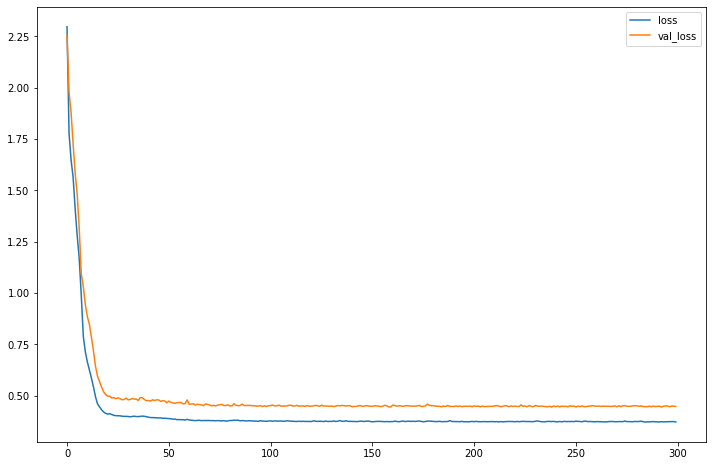

In [35]:
pd.DataFrame(history3.history).plot(figsize=(12,8))

In [36]:
window3_x_encoded

,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
1959-03-01,0.0,0.000000,38.894829,16.903425,21.617584,16.618116,62.060375,5.379772,25.764874,5.677433
1959-04-01,0.0,0.000000,25.547655,20.994043,15.814174,11.665965,52.503193,0.000000,18.611591,4.268267
1959-05-01,0.0,0.000000,26.249651,21.085129,15.962972,11.650425,52.828583,0.000000,18.658806,3.979006
1959-06-01,0.0,0.000000,24.389324,21.340378,15.750158,11.305600,52.147709,0.000000,17.704445,4.347593
1959-07-01,0.0,0.000000,4.709722,31.622463,9.080760,2.930454,39.342319,0.000000,7.069740,3.986208
...,...,...,...,...,...,...,...,...,...,...
2009-08-01,0.0,0.000000,45.124649,16.548685,17.645466,15.476517,62.169559,4.638099,25.302458,2.082880
2009-09-01,0.0,0.000000,59.902809,11.855349,24.836323,21.301355,73.261841,11.251431,33.253773,4.089055
2009-10-01,0.0,5.603801,0.007806,37.314240,0.000000,0.000000,31.453667,0.000000,0.000000,0.000000


In [37]:
window3_x_encoded.sum()

0      634.107056
1     3027.601318
2    13554.888672
3    17183.341797
4     8040.548828
5     5081.269531
6    29138.531250
7     2294.300537
8     7777.448242
9     3417.852783
dtype: float32

In [38]:
window3_x_encoded.drop(window3_x_encoded.columns[[0]], axis=1, inplace=True)
window3_x_encoded

,1,2,3,4,5,6,7,8,9
date,,,,,,,,,
1959-03-01,0.000000,38.894829,16.903425,21.617584,16.618116,62.060375,5.379772,25.764874,5.677433
1959-04-01,0.000000,25.547655,20.994043,15.814174,11.665965,52.503193,0.000000,18.611591,4.268267
1959-05-01,0.000000,26.249651,21.085129,15.962972,11.650425,52.828583,0.000000,18.658806,3.979006
1959-06-01,0.000000,24.389324,21.340378,15.750158,11.305600,52.147709,0.000000,17.704445,4.347593
1959-07-01,0.000000,4.709722,31.622463,9.080760,2.930454,39.342319,0.000000,7.069740,3.986208
...,...,...,...,...,...,...,...,...,...
2009-08-01,0.000000,45.124649,16.548685,17.645466,15.476517,62.169559,4.638099,25.302458,2.082880
2009-09-01,0.000000,59.902809,11.855349,24.836323,21.301355,73.261841,11.251431,33.253773,4.089055
2009-10-01,5.603801,0.007806,37.314240,0.000000,0.000000,31.453667,0.000000,0.000000,0.000000


In [39]:
mse_autoencoder_3, mse_ar4_3, RMSE_3 = Forecast(window3_x_encoded, window3_x, window3_y, window3_y_test, window3_y_all)
RMSE.append(RMSE_3)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: 

In [40]:
RMSE

[1.1257829123084027, 1.220821891695937, 1.0970124154686935]

### Window 4

*   Training Set：1959/3 - 1999/12
*   Test Set：2000/1 - 2022/2

In [41]:
# Training Set：1959/3-1999/12
window4_x = df.loc[:'1999-12-01',:]
window4_y = y[:'1999-12-01']
# Test Set：1999/1-2022/2
window4_x_test = df.loc['2000-01-01':'2022-04-01',:]
window4_y_test = y['2000-01-01':'2022-04-01']
# All
window4_x_all = pd.concat([window4_x, window4_x_test])
window4_y_all = pd.concat([window4_y, window4_y_test])

In [42]:
history4, window4_x_encoded = Autoencoder(window4_x, window4_x_all)

Epoch 1/300
23/23 [==============================] - 1s 8ms/step - loss: 1.9269 - val_loss: 2.1578
Epoch 2/300
23/23 [==============================] - 0s 4ms/step - loss: 1.7429 - val_loss: 2.0931
Epoch 3/300
23/23 [==============================] - 0s 4ms/step - loss: 1.7130 - val_loss: 2.0236
Epoch 4/300
23/23 [==============================] - 0s 4ms/step - loss: 1.5493 - val_loss: 1.7764
Epoch 5/300
23/23 [==============================] - 0s 3ms/step - loss: 1.3664 - val_loss: 1.6665
Epoch 6/300
23/23 [==============================] - 0s 4ms/step - loss: 1.2339 - val_loss: 1.4388
Epoch 7/300
23/23 [==============================] - 0s 4ms/step - loss: 0.9291 - val_loss: 1.1801
Epoch 8/300
23/23 [==============================] - 0s 4ms/step - loss: 0.7726 - val_loss: 1.0710
Epoch 9/300
23/23 [==============================] - 0s 4ms/step - loss: 0.7174 - val_loss: 1.0115
Epoch 10/300
23/23 [==============================] - 0s 4ms/step - loss: 0.6576 - val_loss: 0.9261
Epoch 11/

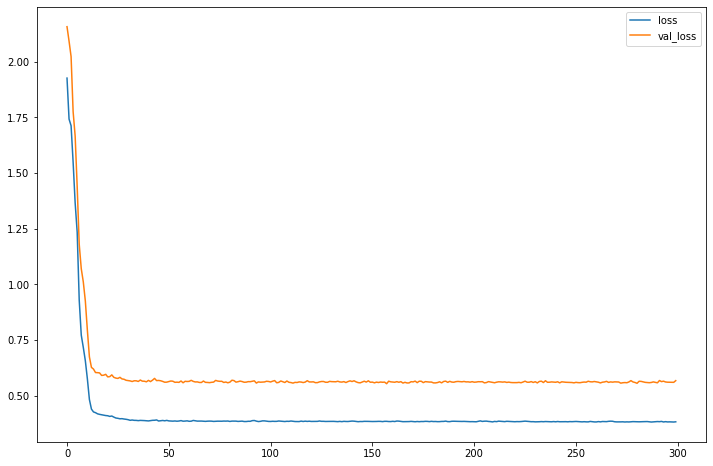

In [43]:
pd.DataFrame(history4.history).plot(figsize=(12,8))

In [44]:
window4_x_encoded

,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
1959-03-01,43.413429,0.000000,31.782928,38.346878,0.0,0.0,0.0,0.0,38.478027,0.0
1959-04-01,32.785538,0.000000,34.941288,25.373499,0.0,0.0,0.0,0.0,25.499075,0.0
1959-05-01,33.322636,0.000000,34.946095,25.902399,0.0,0.0,0.0,0.0,25.472132,0.0
1959-06-01,31.798399,0.000000,35.222633,24.297291,0.0,0.0,0.0,0.0,24.749481,0.0
1959-07-01,15.875934,0.000000,39.661594,5.850983,0.0,0.0,0.0,0.0,4.731242,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-10-01,133.984039,5.366724,1.690356,143.142014,0.0,0.0,0.0,0.0,149.239365,0.0
2021-11-01,14.186922,0.000000,40.921139,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2021-12-01,163.199722,9.772248,0.000000,175.440933,0.0,0.0,0.0,0.0,183.901459,0.0


In [45]:
window4_x_encoded.sum()

0    25657.148438
1      241.611267
2    26208.058594
3    18626.230469
4        0.000000
5        0.000000
6      513.375122
7        0.000000
8    19403.943359
9        0.000000
dtype: float32

In [46]:
window4_x_encoded.drop(window4_x_encoded.columns[[4,5,7,9]], axis=1, inplace=True)
window4_x_encoded

,0,1,2,3,6,8
date,,,,,,
1959-03-01,43.413429,0.000000,31.782928,38.346878,0.0,38.478027
1959-04-01,32.785538,0.000000,34.941288,25.373499,0.0,25.499075
1959-05-01,33.322636,0.000000,34.946095,25.902399,0.0,25.472132
1959-06-01,31.798399,0.000000,35.222633,24.297291,0.0,24.749481
1959-07-01,15.875934,0.000000,39.661594,5.850983,0.0,4.731242
...,...,...,...,...,...,...
2021-10-01,133.984039,5.366724,1.690356,143.142014,0.0,149.239365
2021-11-01,14.186922,0.000000,40.921139,0.000000,0.0,0.000000
2021-12-01,163.199722,9.772248,0.000000,175.440933,0.0,183.901459


In [47]:
mse_autoencoder_4, mse_ar4_4, RMSE_4 = Forecast(window4_x_encoded, window4_x, window4_y, window4_y_test, window4_y_all)
RMSE.append(RMSE_4)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: 

## Result

In [48]:
RMSE

[1.1257829123084027, 1.220821891695937, 1.0970124154686935, 1.1031533305598047]